In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
%matplotlib inline

from tqdm.notebook import tqdm
import os
import imageio

plt.rcParams['figure.figsize'] = (14, 11)
plt.rcParams['font.size'] = 20
plt.rcParams['image.cmap'] = 'binary'

In [2]:
class SchellingModel(object):
    def __init__(self,
                 ratio,
                 grid=[100, 100],
                 empty_house_frac=0,
                 white_frac=0.5,
                 seed=42,
                 create_gif=True):
        assert len(grid) in (1, 2)
        assert 0 <= ratio <= 1
        
        self.ratio = ratio
        self.grid = np.empty(grid)
        self.g_size = grid
        self.empty_house_frac = 0
        self.white_frac = white_frac
        self.n_neigh = 2 if len(grid) == 1 else 8
        self.rng = np.random.default_rng(seed)
        self.create_gif = create_gif
        return
    
    def __call__(self, num_iter=100, frame_per_pic=2):
        self.randomStart()
        if self.create_gif:
            self.filenames = []
        flag = False
        left_moves = []
        
        pbar = tqdm(range(num_iter))
        pbar.set_description(f'R = {self.ratio}. Iteration #0')
        for n in pbar:
            move_grid = self.moveGrid()

            if len(move_grid) <= 1:
                print(f'Done!\n{n} iterations out of {num_iter}')
                flag = True
            else:
                move_grid = np.vstack(move_grid)
                self.randomMove(move_grid)
                pbar.set_description(f'R = {self.ratio}. Iteration #{n+1}, agents moved: {move_grid.shape[0]}')
                left_moves.append(move_grid.shape[0])
            
            if self.create_gif:
                self.plotGrid(n, for_gif=self.create_gif, frame_per_pic=frame_per_pic)
            if flag:
                break
 
        if self.create_gif:
            self.makeGif(name='Trifonov_schell_model_' + str(self.ratio))
        
        # grid_left = self.moveGrid()
        # left_moves = grid_left.shape[0] if not isinstance(grid_left, list) else len(grid_left)
        # assert (n == num_iter) & (left_moves <= 1), f'{left_moves} agents still want to relocate!'
        return left_moves
    
    def randomStart(self, ):
        grid_ravel_idx = np.arange(np.prod(self.g_size))
        self.grid = np.empty(np.prod(self.g_size))
        
        w_size = (1 - self.empty_house_frac) * self.white_frac * self.grid.shape[0]
        b_size = (1 - self.empty_house_frac) * (1 - self.white_frac) * self.grid.shape[0]
                
        w_start = self.rng.choice(grid_ravel_idx, size=int(w_size), replace=False)
        grid_ravel_idx = np.delete(grid_ravel_idx, w_start)
        b_start = self.rng.choice(grid_ravel_idx, size=int(b_size), replace=False)
        
        self.grid[:] = np.nan
        self.grid[w_start] = 1
        self.grid[b_start] = 0
        self.grid = np.reshape(self.grid, self.g_size)
        return
       
    def moveGrid(self, ):
        move_grid = []
        corner_cond = lambda i, j: ((i == 0) & (j == 0)) | ((i == self.g_size[0]-1) & (j == 0)) |((i == 0) & (j == self.g_size[1]-1)) | ((i == self.g_size[0]-1) & (j == self.g_size[1]-1))
        bound_cond = lambda i, j: (i == 0) | (j == 0) | (i == self.g_size[0]-1) | (j == self.g_size[1]-1)
        
        for i in range(self.g_size[0]):
            for j in range(self.g_size[1]):
                if corner_cond(i, j):
                    agent, state = self.checkCorner(i, j)
                elif bound_cond(i, j):
                    agent, state = self.checkBoundary(i, j)
                else:
                    agent, state = self.checkNeighbour(i, j)
                
                if state == 'move':
                    move_grid.append((agent, i, j))
        return move_grid

    def randomMove(self, move_grid):
        agents_permuted = self.rng.permutation(move_grid[:, 0])
        move_pos = move_grid[:, [1, 2]] 
        
        for ag, pos_i, pos_j in zip(agents_permuted, move_pos[:, 0], move_pos[:, 1]):
            self.grid[int(pos_i), int(pos_j)] = ag
        return

    def checkNeighbour(self, i, j):
        agent = self.grid[i, j]
        neighbourhood = self.grid[i-1:i+1+1, j-1:j+1+1]
        neighbourhood = np.count_nonzero(neighbourhood == agent) - 1

        if (neighbourhood / self.n_neigh) <= self.ratio:
            return agent, 'move'
        else:
            return agent, 'stay'
            
    def checkBoundary(self, i, j):
        agent = self.grid[i, j]
        
        if i == 0:
            neighbourhood_1 = self.grid[i:i+1+1, j-1:j+1+1]
            neighbourhood_2 = self.grid[self.g_size[0]-1, j-1:j+1+1]
        elif i == self.g_size[0] - 1:
            neighbourhood_1 = self.grid[i-1:i+1, j-1:j+1+1]
            neighbourhood_2 = self.grid[0, j-1:j+1+1]
            
        elif j == 0:
            neighbourhood_1 = self.grid[i-1:i+1+1, j:j+1+1]
            neighbourhood_2 = self.grid[i-1:i+1+1, self.g_size[1]-1]
        elif j == self.g_size[1] - 1:
            neighbourhood_1 = self.grid[i-1:i+1+1, j-1:j+1]
            neighbourhood_2 = self.grid[i-1:i+1+1, 0]
        
        neighbourhood_1 = np.count_nonzero(neighbourhood_1 == agent) - 1
        neighbourhood_2 = np.count_nonzero(neighbourhood_2 == agent)
        neighbourhood = neighbourhood_1 + neighbourhood_2
        
        if (neighbourhood / self.n_neigh) <= self.ratio:
            return agent, 'move'
        else:
            return agent, 'stay'
    
    def checkCorner(self, i, j):
        agent = self.grid[i, j]
        
        if (i == 0) & (j == 0):
            neighbourhood_1 = self.grid[i:i+1+1, j:j+1+1]
            neighbourhood_2 = self.grid[self.g_size[0]-1, j:j+1+1]
            neighbourhood_3 = self.grid[i:i+1+1, self.g_size[1]-1]

        elif (i == self.g_size[0]-1) & (j == 0):
            neighbourhood_1 = self.grid[i:i+1+1, j-1:j+1]
            neighbourhood_2 = self.grid[self.g_size[0]-1, j-1:j+1]
            neighbourhood_3 = self.grid[i:i+1+1, 0]
            
        elif (i == 0) & (j == self.g_size[1]-1):
            neighbourhood_1 = self.grid[i-1:i+1, j:j+1+1]
            neighbourhood_2 = self.grid[0, j:j+1+1]
            neighbourhood_3 = self.grid[i-1:i+1, self.g_size[1]-1]
        
        elif (i == self.g_size[0]-1) & (j == self.g_size[1]-1):
            neighbourhood_1 = self.grid[i-1:i+1, j-1:j+1]
            neighbourhood_2 = self.grid[0, j-1:j+1]
            neighbourhood_3 = self.grid[i-1:i+1, 0]
        
        neighbourhood_1 = np.count_nonzero(neighbourhood_1 == agent) - 1
        neighbourhood_2 = np.count_nonzero(neighbourhood_2 == agent)
        neighbourhood_3 = np.count_nonzero(neighbourhood_3 == agent)
        neighbourhood = neighbourhood_1 + neighbourhood_2 + neighbourhood_3
                                        
        if (neighbourhood / self.n_neigh) <= self.ratio:
            return agent, 'move'
        else:
            return agent, 'stay'
        
    def plotGrid(self, iter_, for_gif=True, frame_per_pic=2):
        plt.imshow(self.grid)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'R = {self.ratio}, grid {self.g_size[0]}x{self.g_size[0]}');
        
        if for_gif:
            for j in range(frame_per_pic):
                filename = f'{iter_}_' + str(j) + '.png'
                self.filenames.append(filename)
                
                plt.savefig('schell_model_pics/' + filename)
            plt.close()
        return
        
    def makeGif(self, name='Trifonov_schell_model'):
        with imageio.get_writer(f'{name}.gif', mode='I') as writer:
            for filename in self.filenames:
                image = imageio.imread('schell_model_pics/' + filename)
                writer.append_data(image)

        for filename in set(self.filenames):
            os.remove('schell_model_pics/' + filename)
        return

In [3]:
N = 300
all_left_moves = []

for r in [0, 1/8, 2/8, 3/8, 4/8, 5/8, 6/8, 7/8, 1]:
    schell_m = SchellingModel(r, grid=[100, 100], empty_house_frac=0, white_frac=0.5, seed=42, create_gif=True)
    left_moves = schell_m(N, 4)
    all_left_moves.append(left_moves)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

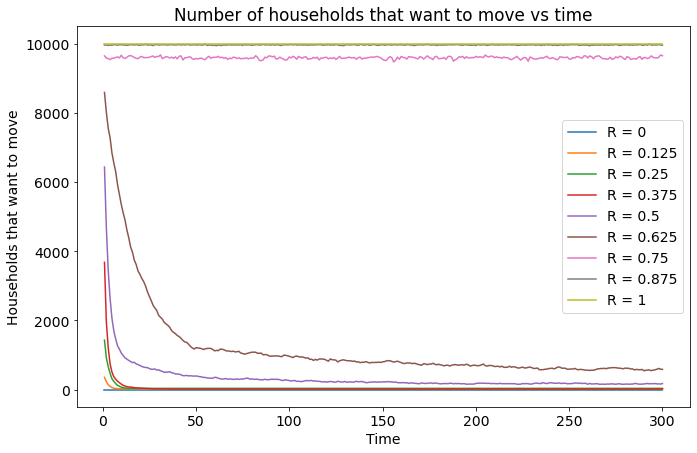

In [4]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (11, 7)

for r, moves in zip([0, 1/8, 2/8, 3/8, 4/8, 5/8, 6/8, 7/8, 1], all_left_moves):
    if r == 0:
        plt.plot(range(1, N+1), [0] * N, label=f'R = {r}')
    else:
        plt.plot(range(1, N+1), moves, label=f'R = {r}')

    plt.xlabel('Time')
    plt.ylabel('Households that want to move')
    plt.title('Number of households that want to move vs time')
    plt.legend();

/tmp/ipykernel_2065/3368503140.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


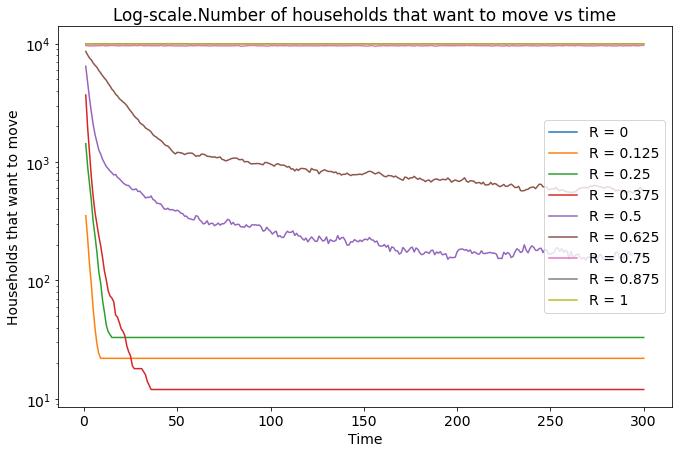

In [5]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (11, 7)

for r, moves in zip([0, 1/8, 2/8, 3/8, 4/8, 5/8, 6/8, 7/8, 1], all_left_moves):
    if r == 0:
        plt.plot(range(1, N+1), [0] * N, label=f'R = {r}')
    else:
        plt.plot(range(1, N+1), moves, label=f'R = {r}')

    plt.xlabel('Time')
    plt.ylabel('Households that want to move')
    plt.yscale('log')
    plt.title('Log-scale.Number of households that want to move vs time')
    plt.legend();